In [1]:
from devito import *
from examples.seismic.source import WaveletSource
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent = (2000., 2000.)
shape = (81, 81)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

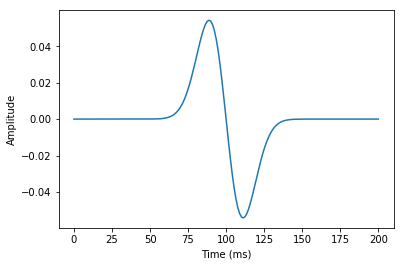

In [3]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1./f0) * np.exp(-a * (t - 1./f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 200.
dt = 1e2*(1. / np.sqrt(2.)) / 60.
nt = int(1 + (tn-t0) / dt)  # Discrete time axis length
time = np.linspace(t0, tn, nt)  # Discrete modelling time

src = DGaussSource(name='src', grid=grid, f0=0.01, time=time)
src.coordinates.data[:] = [1000., 1000.]
src.show()

In [4]:
# Now we create the velocity and pressure fields
p = TimeFunction(name='p', grid=grid)
vx= TimeFunction(name='vx', grid=grid, staggered=(0, 1, 0))
vz = TimeFunction(name='vz', grid=grid, staggered=(0, 0, 1))

P = p.indexed
VX = vx.indexed
VZ = vz.indexed

In [5]:
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 4.0
#V_s = 1.0
density = 3.

dx = 100.
rox = 1/density * dt/x.spacing
roz = 1/density * dt/z.spacing
l2m = V_p*V_p*density * dt/x.spacing

c1 = 9.0/8.0;
c2 = -1.0/24.0;

# The source injection term
src_p = src.inject(field=p, expr=src)


# 2nd order acoustic according to fdelmoc
u_vx_2 = Eq(vx.forward, vx + rox * (-P[t, x, z] + P[t, x-1, z]), region=INTERIOR)
          
#vz[ix*n1+iz] -= roz[ix*n1+iz]*(p[ix*n1+iz] - p[ix*n1+iz-1]);
u_vz_2 = Eq(vz.forward, vz + roz * (-P[t, x, z] + P[t, x, z-1]), region=INTERIOR)

u_p_2 = Eq(p.forward, p + l2m * ( (-VX[t+1, x+1, z] + VX[t+1, x, z]) + (-VZ[t+1, x, z+1] + VZ[t+1, x, z])), region=INTERIOR)

op_2 = Operator(src_p + [u_vx_2, u_vz_2, u_p_2], dse=None, dle=None)


# 4th order acoustic according to fdelmoc
u_vx_4 = Eq(vx.forward, vx - rox * (c1*(P[t, x, z] - P[t, x-1, z]) + c2*(P[t, x+1, z] - P[t, x-2, z])))

u_vz_4 = Eq(vz.forward, vz - roz * (c1*(P[t, x, z] - P[t, x, z-1]) + c2*(P[t, x, z+1] - P[t, x, z-2])))

u_p_4 = Eq(p.forward, p - l2m * (c1*(VX[t+1, x+1, z] - VX[t+1, x, z]) + c2*(VX[t+1, x+2, z] - VX[t+1, x-1, z])
                               + c1*(VZ[t+1, x, z+1] - VZ[t+1, x, z]) + c2*(VZ[t+1, x, z+2] - VZ[t+1, x, z-1])))

op_4 = Operator(src_p + [u_vx_4, u_vz_4, u_p_4], dse=None, dle=None)

CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-bihdf6py/4826abc126537a3d014350b07349073b60e7e0c0.c [0.35 s]
Section section_0<170,1> with OI=3.10 computed in 0.000 s [1.51 GFlops/s]
Section main<170,80,80> with OI=0.58 computed in 0.018 s [0.85 GFlops/s, 0.06 GPts/s]


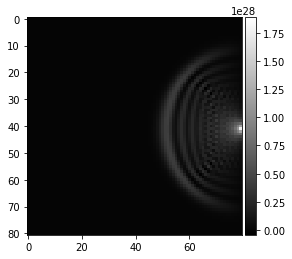

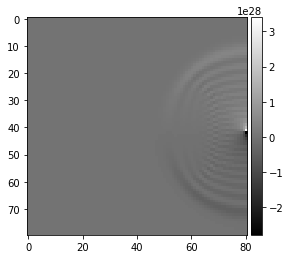

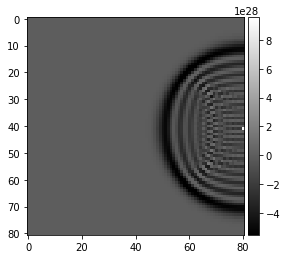

In [6]:
### 2nd order acoustic

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
p.data[:] = 0.


op_2(time=nt-1)

# Let's see what we got....
plot_image(vx.data[0])
plot_image(vz.data[0])
plot_image(p.data[0])

CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-bihdf6py/9a94d47d5a86a4a5bec4c5663d4e86748fec7341.c [0.41 s]
Section section_0<170,1> with OI=3.10 computed in 0.000 s [0.66 GFlops/s]
Section main<170,77,77> with OI=1.58 computed in 0.074 s [0.52 GFlops/s, 0.01 GPts/s]


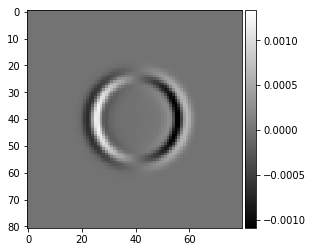

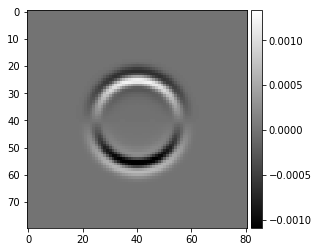

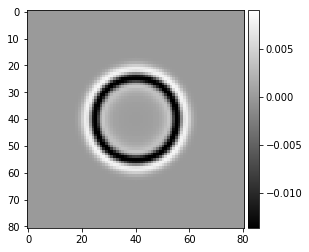

In [7]:
### 4th order acoustic

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
p.data[:] = 0.

op_4(time=nt-1)

# Let's see what we got....
plot_image(vx.data[0])
plot_image(vz.data[0])
plot_image(p.data[0])